# Study Question 3.4.2

a) The age of the bottle bought $A$ (old = 0, new = 1) influences the presence of the active ingredient $I$ (0 = not present, 1 = present), which in turn influences the chance of recovery $R$ (0 = no recovery, 1 = recovery).

To this we introduce the customer $C$ (0 = poor customer, 1 = rich customer) as a confounding factor. Rich customers have preference for the expensive newer bottle, whereas poor customers have a preference for the cheaper older bottle. Whether a customer is rich or poor also influences their chance of recovery.

This gives the following causal graph

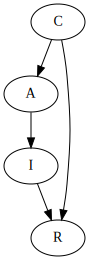

In [95]:
from graphviz import Digraph

dot = Digraph()

dot.node('C')
dot.node('A')
dot.node('I')
dot.node('R')

dot.edge('A', 'I')
dot.edge('I', 'R')
dot.edge('C', 'A')
dot.edge('C', 'R')


dot

b) We assign the following probabilities

Our population has more poor customers.
$$P(C = 0) = 0.8$$

Poor customers are less likely to buy the expensive newer bottle.
$$P(A = 1 \mid C = 0) = 0.1$$
$$P(A = 1 \mid C = 1) = 0.9$$

The presence of active ingredients given age are provided in the question.
$$P(I = 1 \mid A = 0) = 0.05$$
$$P(I = 1 \mid A = 1) = 0.95$$

Having the active ingredient gives a better outcome for both the poor and the rich customers. However, poor customers have a better underlying chance of recovery because caviar consumption is a risk factor.

$$P(R = 1 \mid C = 0,  I = 0) = 0.6$$
$$P(R = 1 \mid C = 0,  I = 1) = 0.7$$
$$P(R = 1 \mid C = 1,  I = 0) = 0.2$$
$$P(R = 1 \mid C = 1,  I = 1) = 0.3$$

Simulating a dataset with these values, we find that the observed probability of recovery is lower if the expensive newer bottle is bought than if the cheaper older bottle is bought. Similarly, we find that the observed probability of recovery is lower if the active ingredient is taken, than if it isn't.

In [50]:
n = 1000000

# C = 0 poor customer, C = 1 rich customer
p_poor = 0.8
p_rich = 1 - p_poor
C = (np.random.uniform(size = n) < p_rich) * 1

# A = 0 old bottle bought, A = 1 new bottle bought
p_buy_new_bottle_if_poor = 0.1
p_buy_new_bottle_if_rich = 0.9
A = np.zeros_like(C)
A[C == 0] = (np.random.uniform(size = np.sum(C == 0)) < p_buy_new_bottle_if_poor) * 1
A[C == 1] = (np.random.uniform(size = np.sum(C == 1)) < p_buy_new_bottle_if_rich) * 1

# I = 0 has no active ingredient, I = 1 has active ingredient
I = np.zeros_like(A)
I[A == 0] = (np.random.uniform(size = np.sum(A == 0)) < 0.05) * 1
I[A == 1] = (np.random.uniform(size = np.sum(A == 1)) < 0.95) * 1

# R = 0 customer does not recover, R = 1 customer recovers
p_recover_poor_with_ingredient = 0.7
p_recover_poor_no_ingredient = 0.6
p_recover_rich_with_ingredient = 0.3
p_recover_rich_no_ingredient = 0.2
R = np.zeros_like(I)
mask = np.logical_and(C == 0, I == 1)
R[mask] = (np.random.uniform(size = np.sum(mask)) < p_recover_poor_with_ingredient) * 1
mask = np.logical_and(C == 0, I == 0)
R[mask] = (np.random.uniform(size = np.sum(mask)) < p_recover_poor_no_ingredient) * 1
mask = np.logical_and(C == 1, I == 1)
R[mask] = (np.random.uniform(size = np.sum(mask)) < p_recover_rich_with_ingredient) * 1
mask = np.logical_and(C == 1, I == 0)
R[mask] = (np.random.uniform(size = np.sum(mask)) < p_recover_rich_no_ingredient) * 1


print(f'Prob of recovering if expensive bottle bought = {np.mean(R[A == 1])}')
print(f'Prob of recovering if cheap bottle bought = {np.mean(R[A == 0])}')
print()
print(f'Prob of recovering if active ingredient bottle bought = {np.mean(R[I == 1])}')
print(f'Prob of recovering if no active ingredient bottle bought = {np.mean(R[I == 0])}')

Prob of recovering if expensive bottle bought = 0.4179518601586164
Prob of recovering if cheap bottle bought = 0.5943584521935001

Prob of recovering if active ingredient bottle bought = 0.45740778623477213
Prob of recovering if no active ingredient bottle bought = 0.5846618300175582


In [72]:
import pandas as pd

df = pd.DataFrame({'Age': A, 'Ingredient': I, 'Recovery': R})

df['Age'] = df['Age'].transform(lambda x: 'old' if x == 0 else 'new')
df['Ingredient'] = df['Ingredient'].transform(lambda x: 'not present' if x == 0 else 'present')
df['Recovery'] = df['Recovery'].transform(lambda x: 'does not recover' if x == 0 else 'recovers')

df.groupby(['Age', 'Ingredient', 'Recovery']).size()

Age  Ingredient   Recovery        
new  not present  does not recover      8801
                  recovers              4180
     present      does not recover    142237
                  recovers            104276
old  not present  does not recover    288778
                  recovers            414715
     present      does not recover     11602
                  recovers             25411
dtype: int64

We want to calculate $P(R|\textit{do}(A))$. There is a backdoor path from $A \rightarrow C \leftarrow R$, but we cannot block this by conditioning on $C$, since this is unobserved.

Therefore, we need to use the frontdoor adjustment, conditioning on $I$. This gives us

$$
P(R = r|\textit{do}(A = a)) = \sum_{i \in I} P(I = i\mid A = a)\sum_{a^\prime \in A}P(R=r\mid A=a^\prime, I = i)P(A = a^\prime)
$$

In [57]:
#P(R = 1|do(A = 0))

#P(I = 0|A = 0) . (P(R = 1|A = 0, I = 0)P(A = 0) + P(R = 1|A = 1, I = 0)P(A = 1))
term_one = np.mean(I[A == 0] == 0) * (
    np.mean(R[np.logical_and(A == 0, I == 0)])*np.mean(A == 0) +
    np.mean(R[np.logical_and(A == 1, I == 0)])*np.mean(A == 1)
)

#P(I = 1|A = 0) . (P(R = 1|A = 0, I = 1)P(A = 0) + P(R = 1|A = 1, I = 1)P(A = 1))
term_two = np.mean(I[A == 0] == 1) * (
    np.mean(R[np.logical_and(A == 0, I == 1)])*np.mean(A == 0) +
    np.mean(R[np.logical_and(A == 1, I == 1)])*np.mean(A == 1)
)

p_r_1_do_a_0 = term_one + term_two

#P(R = 1|do(A = 1))

#P(I = 0|A = 1) . (P(R = 1|A = 0, I = 0)P(A = 0) + P(R = 1|A = 1, I = 0)P(A = 1))
term_one = np.mean(I[A == 1] == 0) * (
    np.mean(R[np.logical_and(A == 0, I == 0)])*np.mean(A == 0) +
    np.mean(R[np.logical_and(A == 1, I == 0)])*np.mean(A == 1)
)

#P(I = 1|A = 1) . (P(R = 1|A = 0, I = 1)P(A = 0) + P(R = 1|A = 1, I = 1)P(A = 1))
term_two = np.mean(I[A == 1] == 1) * (
    np.mean(R[np.logical_and(A == 0, I == 1)])*np.mean(A == 0) +
    np.mean(R[np.logical_and(A == 1, I == 1)])*np.mean(A == 1)
)

p_r_1_do_a_1 = term_one + term_two

print(f'P(R = 1|do(A = 0)) = {p_r_1_do_a_0}')
print(f'P(R = 1|do(A = 1)) = {p_r_1_do_a_1}')

P(R = 1|do(A = 0)) = 0.5249953709824946
P(R = 1|do(A = 1)) = 0.6132504241489463


From above we see that more expensive bottle provides a better chance of recovery on average.